# PlantSegmentation 🌱 + 🔬 - AI4Science: Accelerating experimental loops

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader

from dataset import PlantDataset 
from utils import (
    display_masks, 
    extract_ids_from_name, 
    extract_tag_from_name,
    upscale_logits, # quizas deberian ir al modulo del modelo?
    flatten_logits, # quizas deberian ir al modulo del modelo
    set_seed,
    )

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor
)

from PIL import Image
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


cuda


In [2]:
!nvidia-smi

Fri Apr 21 12:16:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050         On | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P5               N/A /  N/A|     11MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## `PlantDataset` 🌱: navegar por imágenes y máscaras

In [3]:
from dataset import PlantDataset, extract_ids_from_name

dataset = PlantDataset('data', 'cwt', 'data_inventary.csv')

Podemos verificar si `CellDataset` navega correctamente por el directorio
y carga los archivos correctos:

In [5]:
dataset[10]

{'image': <PIL.Image.Image image mode=RGB size=2503x1895>,
 'masks': ['data/cwt/original_labeled/11/task-11-annotation-53-by-1-tag-normal_cut-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-47-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-50-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-51-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-49-by-1-tag-noise-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-52-by-1-tag-normal_cut-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-46-by-1-tag-normal-0.png',
  'data/cwt/original_labeled/11/task-11-annotation-48-by-1-tag-noise-0.png'],
 'labels': [1, 2, 2, 2, 2, 1, 0, 2]}

The image corresponding to idx 4 has the file name 'cwt1_13.jpg'

The name of the folder where the masks are stored is 5, and there are 7 masks:
 -> data/cwt/original_labeled/5/task-5-annotation-24-by-1-tag-normal_cut-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-22-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-21-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-23-by-1-tag-normal-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-27-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-25-by-1-tag-noise-0.png
 -> data/cwt/original_labeled/5/task-5-annotation-26-by-1-tag-noise-0.png
The labels of the masks are [1, 2, 2, 0, 2, 2, 2]


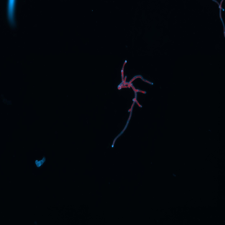

In [6]:
idx=4
img, masks, labels = dataset[idx].values()
print(f"The image corresponding to idx {idx} has the file name '{dataset.images[idx]}'\n")
name_original_img = dataset.images[idx]
id_original_img, id_after_split = extract_ids_from_name(name_original_img)
mask_idx = dataset.idx_table[(dataset.idx_table['id orginal img'] == id_original_img) & 
                             (dataset.idx_table['id after split'] == id_after_split)]['id']._values[0]

print(f"The name of the folder where the masks are stored is {mask_idx}, and there are {len(masks)} masks:")
for mn in masks:
    print(f" -> {mn}")
print(f"The labels of the masks are {labels}")
img.resize((225, 225))

Podemos visualizar las máscaras asociadas a esta imagen con la
función de utilidad `display_masks`.

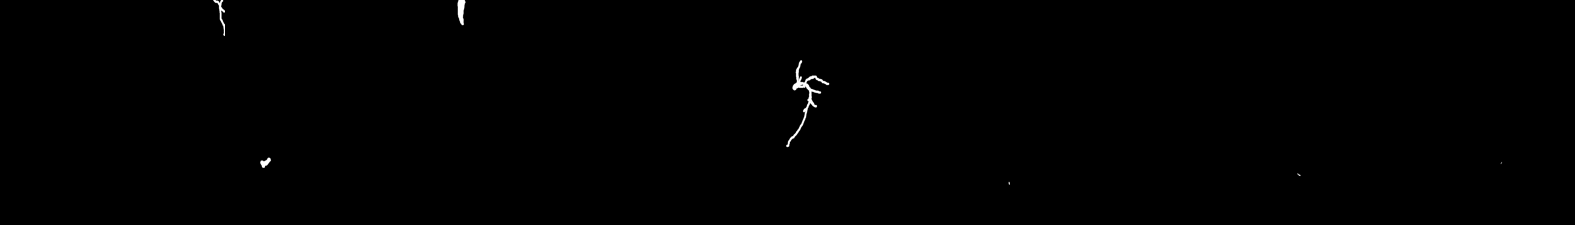

In [7]:
# TODO: analizar el orden de como se stackean las imagenes de la lista de direcciones en masks
# a la PIL.Image en display_masks()
from utils import display_masks
display_masks(masks)

De izquierda a derecha, cada máscara identifica las siguientes instancias.

In [8]:
for idx in labels:
    print(dataset._id2label[idx])

normal_cut
noise
noise
normal
noise
noise
noise


La clase `PlantDataset` contiene dos atributos con los diccionarios para
mapear la clase a un entero (i.e. `_label2id`) y viceversa (`_id2label`).

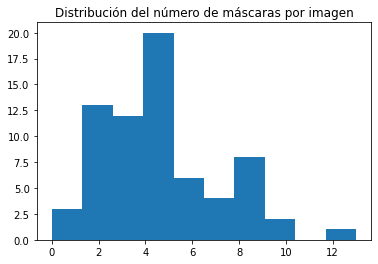

In [9]:
plt.hist(dataset.get_number_of_masks());
plt.title('Distribución del número de máscaras por imagen');

Hay una imagen con 13 máscaras asociadas...

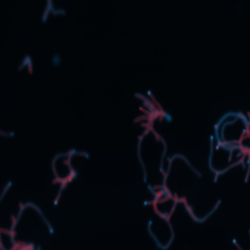

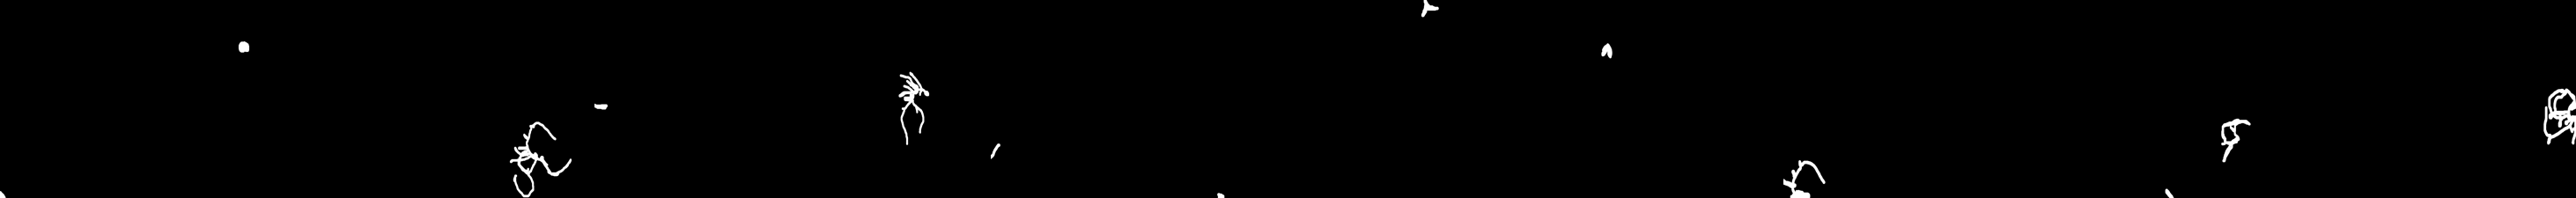

In [10]:
idx_13masks = dataset.get_number_of_masks().index(13)

display(dataset[idx_13masks]['image'].resize((250, 250)))

display_masks(dataset[idx_13masks]['masks'])

## Collate Function + DataLoader: bonito, bonito, pero quiero tensores

### Un canal para cada etiqueta, un entero para cada instancia

Ahora nos enfocaremos en construir el _target_ de una observación. Necesitamos
crear un tensor a partir de todas las posibles máscaras y etiquetas asociadas
a una imagen, dentro del cual se identifican instancias particulares a una clase
dentro de la misma matriz. Tendremos 3 matrices, 1 por cada clase, y todas
apiladas en una dimensión adicional en el mismo tensor. Esto será el _target_
para cada imagen. 

In [12]:
# dado una imagen leer en tensores todas las etiquetas
idx=4
img, masks, labels = dataset[idx].values()
masks

['data/cwt/original_labeled/5/task-5-annotation-24-by-1-tag-normal_cut-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-22-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-21-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-23-by-1-tag-normal-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-27-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-25-by-1-tag-noise-0.png',
 'data/cwt/original_labeled/5/task-5-annotation-26-by-1-tag-noise-0.png']

Usando un solo ejemplo, leemos sus máscaras y las transformamos a
tensores de PyTorch. Agrupamos todos los tensores asociados a una etiqueta,
tenemos 3 distintas, por lo tanto terminamos con 3 tensores que agrupan
en un canal todas las máscaras con la misma etiqueta.

In [13]:
from torchvision.transforms import ToTensor

# obtengamos la información para un ejemplo
idx=4
img, masks, labels = dataset[idx].values()

# crear id de instancias
instance_idxs = torch.tensor([l+1 for l in range(len(labels))], dtype=torch.long)
tfms = ToTensor()

# leer las mascaras por etiquetas, transformarlas a tensores, y concatenarlos en una dimensión
# adicional. Creamos un tensor por cada etiqueta
# TODO: cómo hacerlo todo una pasada?
m0 = torch.cat([torch.where(tfms(Image.open(m).resize((10, 10))) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 0])
m1 = torch.cat([torch.where(tfms(Image.open(m).resize((10, 10))) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 1])
m2 = torch.cat([torch.where(tfms(Image.open(m).resize((10, 10))) > 0.0, 1.0, 0.0) * instance_idxs[l] for l, m in enumerate(masks) if labels[l] == 2])
m0.shape, m1.shape, m2.shape

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([5, 10, 10]))

Notemos que la etiqueta asociada al índice 2 (i.e. `noise`) tiene 5 máscaras
asociadas, las otras dos etiquetas solo una. Necesitamos ahora fundir cada
uno de estos tensores con 3 dimensiones `(mask_id, height, width)` a 
`(height, width)` donde en cada pixel haya un número asociado a la instancia.

Partamos con el tensor que agrupa las máscaras `noise` y tiene 5 instancais
asociadas.

In [14]:
# revisamos sus ids de instancia
print('Id de instancia:', instance_idxs)
m2.unique()

Id de instancia: tensor([1, 2, 3, 4, 5, 6, 7])


tensor([0., 2., 3., 5., 6.])

Recordemos que el valor 0 esta reservado para la etiqueta de ausencia (no label).
Así que las instancias parten desde el 1, ..., a tantas máscaras tenga asociada
la observación. No tienen porque tener un orden asociado según la clase.

Ahora podemos colapsar el canal que tiene cada mascara en una sola, sumando
todas las matrices a lo largo de este canal, element por elemento. Asumiendo
que no tenemos ninguna instancia asolapada, cada pixel debería tener un id
identificando a la máscara particular que pertenece. El resto de los valores
será 0 que significa que no hay ningúna clase que identificamos en ese pixel.

Recordemos que en nuestro ejemplo reducimos la resolución de las máscaras a
10x10 para lograr visualizarlas completa. Estas son las máscaras asociadas
a la etiqueta 2 que es `noise`. Originalmente habían 5 de 7 máscaras en
esta observación que se identifican a esta etiqueta. Sin embargo, en su 
versión matricial solo vemos 4 enteros distintos, esto es porque uno 
se perdió por la reducción de tamaño de imagen. 

Veámos las clases de cada máscara y los ids para identificar a cada una 
de ellas.

In [15]:
m2.sum(dim=0)

tensor([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 2., 0., 0., 0., 0., 6., 0., 0.],
        [0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Si vemos la imagen a clasificar, es posible identificar con los
enteros de la matriz de arriba las zonas donde se clasificaron 
como ruído. Por la resolución, hay un par de puntos que son díficiles
de ver, pero las instancias representadas por 3 y 2 son fáciles de mapear
de la matriz a la imagen.

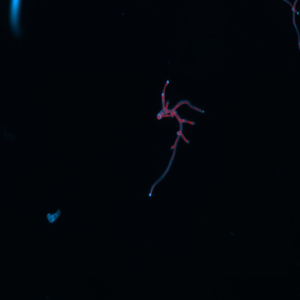

In [16]:
img.resize((300,300))

Este procedimiento se debe realizar por cada clase, luego debemos
apilar 3 matrices como la de arriba, en un solo tensor que tendrá
las dimensiones `(Batch, Clase, Altura, Ancho)` y esta serán nuestras etiquetas
asociadas a la observación.

In [17]:
torch.zeros((1, 3, 10, 10)).shape

torch.Size([1, 3, 10, 10])

In [18]:
dataset._id2label

{0: 'normal', 1: 'normal_cut', 2: 'noise'}

In [19]:
def get_target(masks, labels, tfms, size=(250, 250), num_classes=4):
    """ 
        Recibe una lista de máscaras y una lista de etiquetas, retorna
        un tensor de dimensiones (n_classes, height, widht). En cada clase,
        cualquier entero distinto a 0 representa a uns instancia particular
        de la clase. El entero 0 se reserva para background/no-clase.
    """
    # creamos tensor para almacenar máscaras por clase en cada canal (dim 1)
    # NOTA: la última es ausencia o ninguna detecctión 
    out = torch.zeros((1, num_classes, size[0], size[1]))

    # si no hay máscaras, retornamos el tensor
    if len(masks) == 0:
        return out

    # crear un entero que represente cada instancia de las mascaras asociadas
    # a la observación. No siguen un orden necesario tipo todas las de la clase 0
    # parten al principio, se encuentran según el orden de los labels. El entero
    # 0 se reserva como background/no-clase
    instance_idxs = torch.tensor([l+1 for l in range(len(labels))], dtype=torch.long)

    # iteramos sobre cada clase para procesar las máscaras asociadas a estas,
    # agregar un identificador de instancias y colapsar en una sola matriz
    # Supuesto: no hay clase sobrelapadas. Si hay, se debe hacer un proceso
    # adicional para ver que entero se asigna al pixel correspondiente
    for l in list(set(labels)):
        x = torch.cat([torch.where(tfms(Image.open(m).resize(size)) > 0.0, 1.0, 0.0) * instance_idxs[i] for i, m in enumerate(masks) if labels[i] == l])
        out[0, l, :, :] = x.sum(dim=0)

    return out

In [25]:
idx=0
img, masks, labels = dataset[idx].values()
get_target(masks, labels, tfms, size=((10, 10)))

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [3., 3., 3., 3., 0., 0., 0., 0., 0., 0.],
          [3., 3., 3., 3., 0., 0., 0., 0., 0., 0.],
          [3., 3., 3., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [2., 2., 2., 0., 0., 0., 0., 0., 0., 0.],
          

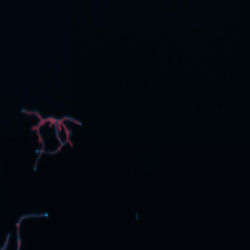

In [27]:
img.resize((250, 250))

### Collate function y DataLoaders

Sabemos como obtener los _targets_ a partir de las máscaras asociadas a una observación.
Ahora, aplicaremos la transformación a la imagen del input.

Primero, las imágenes como _input_ se le aplican una serie de
transformaciones para adaptarlo al modelo SegFormer. Estas transformaciones
se pueden instanciar con `SegformerImageProcessor()`. Toma una imagen
en forma `PIL.Image` y entrega una lista con un array que puede ser
adaptado a numpy, torch, jax, etcétera.

¿Qué pasa con las máscaras?

In [28]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
    
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")


/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

In [30]:
# Create a collate function to stack the masks as channels in the same tensor
def collate_fn(batch):
    """
        Collate function to stack the masks as channels in the same tensor.
    """
    # Acá se pueden agregar todas las transformaciones adicionales de preproceso que
    # se requieran para las máscaras. La única esencial es pasar una PIL.Image a tensor
    tfms = ToTensor()
    images = torch.cat([feature_extractor(example['image'], return_tensors='pt')['pixel_values'] for example in batch])
    masks = [example['masks'] for example in batch]
    labels = [example['labels'] for example in batch]
    targets = torch.cat([get_target(x[0], x[1], tfms, size=(512,512)) for x in zip(masks, labels)])

    # transformar a 1 cuando haya un entero distinto a 0 (semantic segmentation)
    targets = torch.where(targets > 0.0, 1.0, 0.0)
    return images, targets


In [31]:
from torch.utils.data import DataLoader

# Create a DataLoader object to stacking each mask as a channel in the same tensor
# and to shuffle the dataset
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0,
                        collate_fn=collate_fn)

xb, yb = next(iter(dataloader))
xb.shape, yb.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 4, 512, 512]))

## SegFormer

### Sanity check: understanding the output models

In [36]:
dataset._id2label[3] = 'non-detection'
dataset._label2id['non-detection'] = 3

In [37]:
set_seed()  # for reproducibility

# initialize model
dataset._id2label[3] = 'non-detection'
dataset._label2id['non-detection'] = 3

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=dataset._id2label,
    label2id=dataset._label2id
)

# model to device
model=model.to(device)

lr = 1e-4 
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.lin

(torch.Size([2, 3, 512, 512]), torch.Size([2, 4, 512, 512]))

Analicemos el _output_ que nos entrega un modelo al pasarle un
_batch_ con dos ejemplos.

In [38]:
model.eval()
out = model(xb)['logits']
out.shape

torch.Size([2, 4, 128, 128])

Escalamos los logits a la resolución de entrada de la imagen, utilizamos
`upscale_logits`.

In [39]:
out = upscale_logits(out)
out.shape

torch.Size([2, 4, 512, 512])

Necesitamos clasificar cada pixel de la imagen en alguna de las 3 clases posibles
(+1 que es no detección). Utilizamos una función `softmax(out, dim=1)` en
la profundidad de cada pixel para crear una distribución multinomial que
nos entregue la probabilidad de que cada pixel pertenezca a la clase 0, 1, 2 y 3.


Esto sería equivalente a `argmax(out, dim=1)` donde `dim=1` es
la dimensión donde tenemos nuestras etiquetas.

In [40]:
pred_labels = torch.softmax(out, dim=1).detach().cpu()
pred_labels.shape

torch.Size([2, 4, 512, 512])

Entonces, para el primer pixel...

In [41]:
pred_labels[0,:,0,0]

tensor([0.2389, 0.2542, 0.2566, 0.2504])

### Sanity check: overfit a mini-batch with 5 images

In [99]:
set_seed()  # for reproducibility

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=dataset._id2label,
    label2id=dataset._label2id
)

model=model.to(device)

lr = 1e-4 
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# move tensors into the current device
xb=xb.to(device)
yb=yb.to(device)

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.

Predicciones de máscaras con capacidad inicial del modelo.

In [100]:
torch.argmax(torch.softmax(upscale_logits(model(xb)['logits']), dim=1), dim=1).cpu().detach().numpy()[0,:,:]

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 1, 1]])

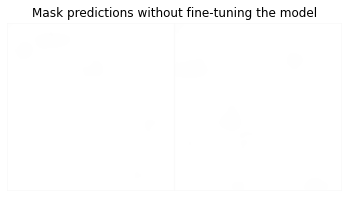

In [42]:
grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

Memorizar las máscaras del _mini-batch_.

In [102]:
set_seed()  # for reproducibility

# the target will be constant (just one batch)
target=flatten_logits(torch.where(yb > 0.0, 1.0, 0.0))
lossi=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Upscale the logit tensor and get the probabilities with the softmax
  probs = torch.softmax(upscale_logits(logits), dim=1)

  # keep it just the probability for the class transform (dim=1) -> binary class
  probs = probs[:, 1, :, :]

  # Transform the. probs tensor into one with shape = (batch_size, 512 x 512)
  preds = flatten_logits(probs)

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss
  loss = loss_fn(preds, target)

  # store the current loss value
  cur_loss = loss.item()
  lossi[idx] = cur_loss

  #print(f"Loss at epoch {idx+1}: {cur_loss:.4f}")

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%100== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f}")

Random seed set as 42313988


  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

Inspeccionemos la curva de pérdida...

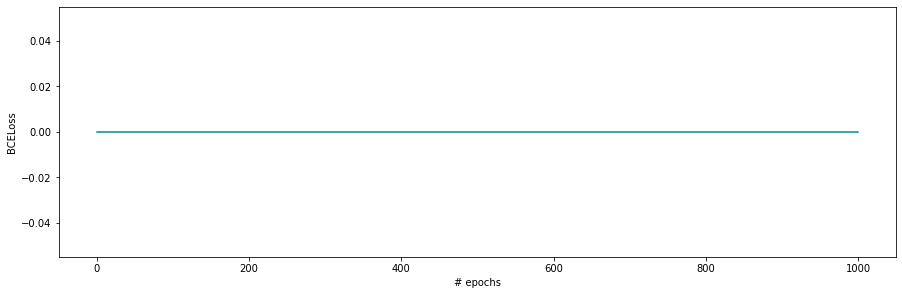

In [103]:
plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("BCELoss");

Ahora veamos las máscaras luego de memorizarlas.

In [ ]:
#@title
grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"After {n_epochs} update steps");

Comparemos con las autenticas máscaras...

In [ ]:
grid=torchvision.utils.make_grid(
    yb.unsqueeze(1).detach(),
    nrow=2,
    padding=8,
    pad_value=8
    )

plt.imshow(grid.permute(1,2,0).cpu());
plt.axis("off");
plt.title("Original masks");